In [6]:
import numpy as np
from utils import ExtractActivities
from StringIO import StringIO

filename = "./data/ann.txt"
activities = ExtractActivities(filename)
file_bin_sensors = "./data/bin_sensors.txt"
bin_sensors = np.loadtxt(file_bin_sensors,dtype=np.str)
con_sensors = np.loadtxt("./data/continue_sensors.txt",dtype=np.str)
labels = np.loadtxt("./data/activities.txt",dtype=np.str)
print("end")

end


In [7]:
def onlybin(activity):
    bin_activity = [activity[0]]
    for i in range(1,len(activity)):
        if len(activity[i]) == 4 and activity[i][2] in bin_sensors:
            bin_activity.append(activity[i])
    return bin_activity
print("end")

end


In [8]:
"""
刚开始只测试前20个行为序列，数据量小，计算快
"""

activities = ExtractActivities(filename)
# print onlybin(activities[0])
bin_activities = []
# for activity in activities[0:20]:
for activity in activities:
    bin_activities.append(onlybin(activity))
print bin_activities[0]
bin_activities = np.array(bin_activities)
activity_labels = [activity[0] for activity in bin_activities]
print bin_activities.shape
print("end")

['Sleep', ['2011-06-15', '02:13:20.812509', 'M007', 'ON'], ['2011-06-15', '02:13:21.919635', 'M007', 'OFF'], ['2011-06-15', '05:40:14.111389', 'M021', 'ON']]
(2655L,)
end


In [9]:
import pandas as pd
# print bin_sensors
df_activity_sensor = pd.DataFrame(index=np.arange(bin_activities.shape[0]),columns=bin_sensors)
activity_sensor_times = np.array([[0 for x in range(len(bin_sensors))] 
                                  for i in range(len(bin_activities))],dtype=np.float16)

for i in range(0,len(bin_activities)):
    current_act = bin_activities[i]
    for j in range(1,len(current_act)):
        col_index = list(bin_sensors).index(current_act[j][2])
        activity_sensor_times[i,col_index] += 1
total_times = activity_sensor_times.sum(axis=1)
tf = activity_sensor_times / total_times[:,np.newaxis]
print tf.shape
print("end")

(2655L, 37L)
end


In [10]:
ac_one = np.zeros((len(bin_activities),len(bin_sensors)))
for i in range(ac_one.shape[0]):
    for j in range(ac_one.shape[1]):
        if activity_sensor_times[i,j] > 0:
            ac_one[i,j] = 1
is_has_sensor = ac_one.sum(axis=1)  
# 文档频率
df = float(ac_one.shape[0])/is_has_sensor
idf = np.log((df+0.01))
print idf.shape

print("end")

(2655L,)
end


In [11]:
sensor_weight = tf * idf[:,np.newaxis]

df_sensor_weights = pd.DataFrame(sensor_weight,columns=bin_sensors,
                                 index=range(len(bin_activities)))
df_sensor_weights.insert(0,'label',activity_labels)
df_sensor_weights[df_sensor_weights['label']=='Sleep'].describe()
print("end")

end


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

%matplotlib inline
# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    print("begin training")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("training num")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="score on train")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="score on cv")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff
print("end")

end


In [13]:
from __future__ import print_function

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC



def findParameters(clf,X,Y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.5, random_state=0)

    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    score = 'r2'

    # clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
    # clf.fit(X_train, y_train)

    # for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

#     clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
print("end")

end


In [14]:
tfidfentrys = list()
targets = []
activity_labels = np.array(activity_labels)

for label in labels:
    current_activity_index = (activity_labels == label)
    # 该类行为的传感器次数矩阵，包含所有的传感器
    current_activity_sensor_times = activity_sensor_times[current_activity_index]

    # 该类行为出现的总次数
    current_activity_times = sum(current_activity_index)

    # 该类行为的传感器权重
    current_activity_sensor_weight = sensor_weight[current_activity_index]

    # 得到当前类中出现的所有传感器下标
    index = current_activity_sensor_weight.sum(axis=0)>0

    # 获取当前行为触发的所有传感器ID
    current_activity_actsensor = bin_sensors[index]
    # print current_activity_actsensor

    # 该类行为触发的所有传感器次数，只包含触发的传感器
    current_activity_actsensor_times = current_activity_sensor_times[:,index]
    current_activity_actsensor_weight = current_activity_sensor_weight[:,index]

    # 该类每种触发的传感器在所有属于该类的样本中出现的总次数
    num = np.zeros((1,len(current_activity_actsensor_times[1])))
    total_times_sensors = current_activity_actsensor_times.sum(axis=0)
    fenmu = total_times_sensors + 0.01
    fenzi = current_activity_actsensor_times +0.01

    # 该类行为激发的传感器的熵Etc：传感器t在c类内的分布熵
    entry = sum(-(fenzi/fenmu) * np.log(fenzi/fenmu))
    
    entry_all = np.zeros(len(bin_sensors))
    entry_all[index] = entry
    # print entry_all
    tfidfe = current_activity_sensor_weight * entry_all
#     print("tfidfe.shape",tfidfe.shape)
    tfidfentrys.extend(tfidfe)
#     print("tfidfentrys",np.shape(tfidfentrys))
    targets.append([label] * current_activity_times )
    
# sensor_entry_inner_class = 

# 还原成最初的shape
print(np.shape(tfidfentrys))
print("end")

(2655L, 37L)
end


In [15]:
X = tfidfentrys
# # Y = [label for label in tgs]
# Y = [label for cls in targets
#     for label in cls]
# # findParameters(X,Y)
Y = np.array([])
for label in labels:
    
    current_activity_index = (activity_labels == label)
    total_time = sum(current_activity_index)
    re_label = np.tile(label,total_time)
    Y = np.append(Y,re_label)
Y = np.array(Y)
print(np.shape(X))
print(Y.shape)
print("end")

(2655L, 37L)
(2655L,)
end


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0)

    # Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores =['r2']

clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
clf.fit(X_train, y_train)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    #     clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
        print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()
print("end")

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'kernel': 'linear', 'C': 1000}

Grid scores on development set:

0.647 (+/-0.036) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}

0.532 (+/-0.022) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}

0.692 (+/-0.021) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

0.614 (+/-0.045) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}

0.765 (+/-0.034) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}

0.700 (+/-0.025) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}

0.825 (+/-0.024) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

0.744 (+/-0.038) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}

0.793 (+/-0.028) for {'kernel': 'linear', 'C': 1}

0.845 (+/-0.027) for {'kernel': 'linear', 'C': 10}

0.852 (+/-0.018) for {'kernel': 'linear', 'C': 100}

0.862 (+/-0.023) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the f

begin training


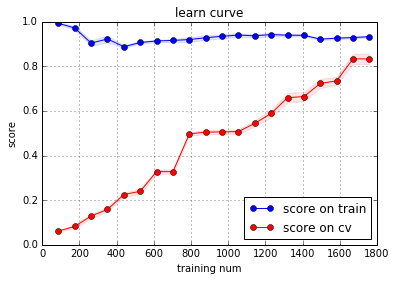

(0.87317013478613292, 0.12705540918464153)

In [18]:
clf = SVC(kernel='linear',C=1000)
plot_learning_curve(clf, "learn curve", X, Y)